# Univariate case path sampling


## Methodology:  see pdf file

## Code implementation


In [1]:
# import library
import numpy as np
import math
from scipy.stats import truncnorm
from scipy.stats import norm
import scipy.integrate as intergrate
import matplotlib.pyplot as plt


In [2]:
"""
Define a class
"""
class Univariate_Normal_Path_sample:
    
    def __init__(self,smin,smax,t,mu,sigma,nsample = None):
        self.smin = smin
        self.smax = smax
        self.t = t
        self.mu = mu
        self.sigma =sigma
        self.sigma_at_t = self.sigma/math.sqrt(self.t)
        if nsample is None:
            self.nsample = 1000
        else: self.nsample = nsample
        self.expectation = None
        self.z = None
         
        """
        Monte Carlo 
        """
    def expectation_z(self):
        a = (smin - self.mu)/self.sigma_at_t
        b = (smax - self.mu)/self.sigma_at_t
        self.z = truncnorm.rvs(a,b,loc=self.mu,\
                               scale = self.sigma_at_t,\
                               size=self.nsample)
        trans_z = (self.z - self.mu)/self.sigma
        self.expectation = -0.5*np.log(2*np.pi)-np.log(self.sigma)-\
        0.5*np.mean(np.power(trans_z,2))

In [3]:
"""
Other functions
"""


def intergrand(smin,smax,t,mu,sigma,nsample=100):
    uni = Univariate_Normal_Path_sample(smin,smax,t,mu,sigma)
    uni.expectation_z()
    return(uni.expectation)


def log_phi1(smin,smax,mu,sigma):
    return(np.log(norm.cdf(smax,loc=mu,scale=sigma)\
                    -norm.cdf(smin,loc=mu,scale=sigma)))
    

def compute_integral(smin,smax,mu,sigma,t_space):
    end_point = np.zeros(t_space.shape[0])
    for i in np.arange(start=0,stop=t_space.shape[0],step=1):
        uni = Univariate_Normal_Path_sample(smin,smax,t_space[i],mu,sigma)
        uni.expectation_z() # compute the expecation
        end_point[i] = uni.expectation
    left_point = end_point[0:-1]
    right_point = end_point[1:]
    final_result = np.multiply(np.diff(t_space),np.mean([left_point,right_point],axis=0))
    return(end_point,np.sum(final_result))
    
    
def true_second_moment(smin,smax,mu,sigma,t):
    sigma0 = 1/math.sqrt(2*t)
    a = 1/math.sqrt(2*sigma)*(smin - mu)
    b = 1/math.sqrt(2*sigma)*(smax - mu)
    alpha = (a-mu)/sigma0
    beta = (b-mu)/sigma0
    phi_alpha = norm.pdf(alpha)
    phi_beta = norm.pdf(beta)
    Phi_alpha = norm.cdf(alpha)
    Phi_beta = norm.cdf(beta)
    Z = Phi_beta - Phi_alpha
    mean_value = mu + (phi_alpha - phi_beta)/Z*sigma0
    var_value = np.power(sigma0,2)*(1+(alpha*phi_alpha-beta*phi_beta)/Z\
                         + np.power((phi_alpha-phi_beta)/Z,2))
    second_m = var_value+np.power(mean_value,2)
    return(-second_m-0.5*np.log(2*np.pi)-np.log(sigma))

## Parameter Setting
Let's assume a normal distribution with mean $\mu =0$ and $\sigma =1$. To simplify the computate, set $smin = -2, smax =2$

In [4]:
smin = -2
smax = 2
mu = 0
sigma = 1


log_phi0 = np.log(smax-smin)

"""
integration error here
"""
result = intergrate.quad(intergrand,0.001,1,args=(smin,smax,mu,sigma))
print('estimation of log phi1-[by intergrate.quad]:',result[0]+log_phi0)


true_log_phi1 = log_phi1(smin=smin,smax=smax,mu=mu,sigma=sigma)


"""
use logspace here
"""
t_space = np.log(np.logspace(start=0.0001,stop=1,base=np.e,num=2000))
#t_space = np.linspace(start=0.001,stop=1,num=2000)
est_log_phi1_per_t,est_log_phi1 = compute_integral(smin,smax,mu,sigma,t_space)


"""
compute true value
"""
true_2nd_moment = [true_second_moment(smin,smax,mu,sigma,t) for t in t_space]


print('estimation of log phi1:', np.sum(est_log_phi1)+log_phi0)
print('true value of log phi1:', true_log_phi1)

C:\Users\z5187692\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  if sys.path[0] == '':


estimation of log phi1-[by intergrate.quad]: 0.22855253162895095
estimation of log phi1: -0.046248117993817894
true value of log phi1: -0.046567912292390164


Text(0, 0.5, 'expectation')

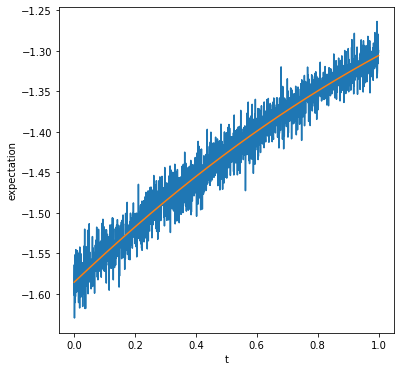

In [5]:
plt.figure(figsize=(6,6))
plt.plot(t_space,est_log_phi1_per_t,t_space,true_2nd_moment)   
plt.xlabel("t")
plt.ylabel("expectation")

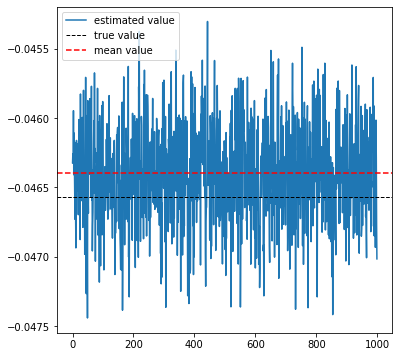

In [6]:
"""
Repeat for 50 times
"""
nrep = 1000
est_log_phi1_array = np.zeros(nrep)

for i in range(nrep):
    _,est_log_phi1_array[i] = compute_integral(smin,smax,mu,sigma,t_space)

plt.figure(figsize=(6,6))
plt.plot(est_log_phi1_array+log_phi0,'-',label='estimated value')
plt.axhline(true_log_phi1, color='k', linestyle='dashed', linewidth=1,\
            label='true value')
plt.axhline(np.mean(est_log_phi1_array)+log_phi0,linestyle='dashed',\
            color='r',label='mean value')
plt.legend()
